In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage

# MagAO-X function definitions
import magaoxFunctions as mf
# draw the dark hole regions
from skimage.draw import draw

# PSD code
from scipy import signal
from scipy import interpolate
import h5py
import copy
import PSD_defns as psd

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#print('This notebook is not stale yet!')

## Let's do some PSDs.

In [2]:
# pre-coat data

opt_parms = {'ca' : 98.5, # of the 80% CA given
             'ovs': 4096,
             'diam_100CA': 50*u.mm,
             'surf_type': 'precoat'}
rpix_full_pc = [152, 154, 253, 129, 127, 131, 131, 131] # known ahead of time
full_diam = 50*u.mm
dr_width = 5

folder_pc = 'zygo_data/oaps/oap_precoated/'
pc_labels =  ('0', '1', '2interp', '3', '4', '5_SN01', '5_SN02', '5_SN03')
ntot = len(pc_labels)

# 2DPSD values
dpix_pc = []
dca_pc = []
latres_pc = []
surf_var_pc = []
dk_pc = []
oap_name_pc = []
surf_data_pc = {}
psd2d_pc = {}
psd2d_norm_pc = {}

# 1DPSD values
kval1D_pc = {}
norm_1Dpsd_pc = {}
cal_1Dpsd_pc = {}
k_ll_pc = []

for ntest in range(0,ntot):
    opt_parms['rpix_full'] = rpix_full_pc[ntest]
    
    # Write filename
    surf_data_loc = 'oap{0}_centered_{1}CA_surf.fits'.format(pc_labels[ntest], str(opt_parms['ca']))
    if ntest < 5:
        n_oap = 'n{0}'.format(ntest)
    else:
        snum = (ntest - 5) + 1 # serial number
        n_oap = 'n5_sn{0}'.format(snum)
    oap_name_pc.append(n_oap)
    opt_parms['oap_name'] = n_oap
    
    # Calculate 2D PSD
    print('Test OAP optic: {0}'.format(n_oap))
    (surf_data_mm, psd2d_opt, norm_psd, FT_freq, opt_parms) = psd.calc_PSD2D(folder_pc, surf_data_loc, opt_parms)
    
    # fill in the parameter space, units come through
    latres_pc.append(opt_parms['latres'])
    dca_pc.append(opt_parms['diam_ca'].value)
    dpix_pc.append(opt_parms['npix_diam_ca'])
    surf_var_pc.append(opt_parms['var'].value)
    dk_pc.append(opt_parms['del_k'].value)
    surf_data_pc[n_oap] = copy.copy(surf_data_mm)
    psd2d_pc[n_oap] = copy.copy(psd2d_opt)
    psd2d_norm_pc[n_oap] = copy.copy(norm_psd)
    
    print('Finished calculating 2D PSD for surface {0}, calculating 1D PSD.'.format(n_oap))
    
    # Calculate the 1D PSD using annular analysis
    k_low = 1/opt_parms['diam_ca']
    cal_psd = norm_psd * opt_parms['var']
    print('calibrated var check: {0:.3f} (should match {1:.3f})'.format(np.sum(cal_psd) * (opt_parms['del_k']**2), opt_parms['var']))
    (kval, mv_n, mv_c) = psd.calc_radialPSD2(norm_psd, cal_psd, FT_freq, dr_width, k_low.value)
    print('norm 1D-PSD units: {1}'.format(n_oap, mv_n.unit)) # should be mm2
    print('cal 1D-PSD units: {1}'.format(n_oap, mv_c.unit))  # should be mm2 nm2
    
    # Save the 1D PSD data
    k_ll_pc.append(k_low)
    kval1D_pc[n_oap] = copy.copy(kval)
    norm_1Dpsd_pc[n_oap] = copy.copy(mv_n)
    cal_1Dpsd_pc[n_oap] = copy.copy(mv_c)
    
    print('1D PSD of surface {0} complete.\n'.format(n_oap))
    
# Apply units
surf_var_pc *= opt_parms['var'].unit
dk_pc *= opt_parms['del_k'].unit
dca_pc *= opt_parms['diam_ca'].unit
print('All 2D PSD measurement tests done.')

Test OAP optic: n0
surf unit check: mm
test diameter: 39.074 mm (78.15% CA)
var: 30.189 nm2
PSD normalized: var=1.000
post-normalization var check: 1.000 (should match 1.000)
Finished calculating 2D PSD for surface n0, calculating 1D PSD.
calibrated var check: 30.189 nm2 (should match 30.189 nm2)
norm 1D-PSD units: mm2
cal 1D-PSD units: mm2 nm2
1D PSD of surface n0 complete.

Test OAP optic: n1
surf unit check: mm
test diameter: 39.121 mm (78.24% CA)
var: 19.041 nm2
PSD normalized: var=1.000
post-normalization var check: 1.000 (should match 1.000)
Finished calculating 2D PSD for surface n1, calculating 1D PSD.
calibrated var check: 19.041 nm2 (should match 19.041 nm2)
norm 1D-PSD units: mm2
cal 1D-PSD units: mm2 nm2
1D PSD of surface n1 complete.

Test OAP optic: n2
surf unit check: mm
test diameter: 39.277 mm (78.55% CA)
var: 16.303 nm2
PSD normalized: var=1.000
post-normalization var check: 1.000 (should match 1.000)
Finished calculating 2D PSD for surface n2, calculating 1D PSD.
cal

In [3]:
%%time
# Coated data

# filter the OAP data
opt_parms = {'ca' : 98.5, # of the 80% CA given
             'ovs': 4096,
             'diam_100CA': 50*u.mm,
             'surf_type': 'coated'}
rpix_full_coat = 388 # known ahead of time
full_diam = 50*u.mm
dr_width = 5

folder_coat = 'zygo_data/oaps/oap_coated/'
coat_labels =  ('0', '1', '2', '3', '4', '5_sn1interp', '5_sn2', '5_sn3interp')
ntot = len(coat_labels)

# 2DPSD values
dpix_coat = []
dca_coat = []
latres_coat = []
surf_var_coat = []
dk_coat = []
oap_name_coat = []
surf_data_coat = {}
psd2d_coat = {}
psd2d_norm_coat = {}

# 1DPSD values
kval1D_coat = {}
norm_1Dpsd_coat = {}
cal_1Dpsd_coat = {}
k_ll_coat = []

for ntest in range(0,ntot):
    opt_parms['rpix_full'] = rpix_full_coat
    
    # Write filename
    surf_data_loc = 'oap{0}_centered_{1}CA_surf.fits'.format(coat_labels[ntest], str(opt_parms['ca']))
    if ntest < 5:
        n_oap = 'n{0}'.format(ntest)
    else:
        snum = (ntest - 5) + 1 # serial number
        n_oap = 'n5_sn{0}'.format(snum)
    oap_name_coat.append(n_oap)
    opt_parms['oap_name'] = n_oap
    
    # Calculate 2D PSD
    print('Test OAP optic: {0}'.format(n_oap))
    (surf_data_mm, psd2d_opt, norm_psd, FT_freq, opt_parms) = psd.calc_PSD2D(folder_coat, surf_data_loc, opt_parms)
    
    # fill in the parameter space, units come through
    latres_coat.append(opt_parms['latres'])
    dca_coat.append(opt_parms['diam_ca'].value)
    dpix_coat.append(opt_parms['npix_diam_ca'])
    surf_var_coat.append(opt_parms['var'].value)
    dk_coat.append(opt_parms['del_k'].value)
    surf_data_coat[n_oap] = copy.copy(surf_data_mm)
    psd2d_coat[n_oap] = copy.copy(psd2d_opt)
    psd2d_norm_coat[n_oap] = copy.copy(norm_psd)
    
    print('Finished calculating 2D PSD for surface {0}, calculating 1D PSD.'.format(n_oap))
    
    # Calculate the 1D PSD using annular analysis
    k_low_coat = 1/opt_parms['diam_ca']
    cal_psd = norm_psd * opt_parms['var']
    print('calibrated var check: {0:.3f} (should match {1:.3f})'.format(np.sum(cal_psd) * (opt_parms['del_k']**2), opt_parms['var']))
    (kval, mv_n, mv_c) = psd.calc_radialPSD2(norm_psd, cal_psd, FT_freq, dr_width, k_low_coat.value)
    print('norm 1D-PSD units: {1}'.format(n_oap, mv_n.unit)) # should be mm2
    print('cal 1D-PSD units: {1}'.format(n_oap, mv_c.unit))  # should be mm2 nm2
    
    # Save the 1D PSD data
    k_ll_coat.append(k_low_coat)
    kval1D_coat[n_oap] = copy.copy(kval)
    norm_1Dpsd_coat[n_oap] = copy.copy(mv_n)
    cal_1Dpsd_coat[n_oap] = copy.copy(mv_c)
    
    print('1D PSD of surface {0} complete.\n'.format(n_oap))

# Apply units
surf_var_coat *= opt_parms['var'].unit
dk_coat *= opt_parms['del_k'].unit
dca_coat *= opt_parms['diam_ca'].unit

print('All 2D and 1D PSD measurement tests done.')

Test OAP optic: n0
surf unit check: mm
test diameter: 39.858 mm (79.72% CA)
var: 105.298 nm2
PSD normalized: var=1.000
post-normalization var check: 1.000 (should match 1.000)
Finished calculating 2D PSD for surface n0, calculating 1D PSD.
calibrated var check: 105.298 nm2 (should match 105.298 nm2)
norm 1D-PSD units: mm2
cal 1D-PSD units: mm2 nm2
1D PSD of surface n0 complete.

Test OAP optic: n1
surf unit check: mm
test diameter: 39.858 mm (79.72% CA)
var: 103.287 nm2
PSD normalized: var=1.000
post-normalization var check: 1.000 (should match 1.000)
Finished calculating 2D PSD for surface n1, calculating 1D PSD.
calibrated var check: 103.287 nm2 (should match 103.287 nm2)
norm 1D-PSD units: mm2
cal 1D-PSD units: mm2 nm2
1D PSD of surface n1 complete.

Test OAP optic: n2
surf unit check: mm
test diameter: 39.858 mm (79.72% CA)
var: 50.747 nm2
PSD normalized: var=1.000
post-normalization var check: 1.000 (should match 1.000)
psd for n2 needs masking to eliminate blips
Finished calculat

In [4]:
# Evaluate the spatial frequency content
k_npts_pc = np.shape(kval1D_pc[oap_name_pc[0]])[0]
k_npts_coat = np.shape(kval1D_coat[oap_name_coat[0]])[0]
print('1D PSD interpolation check: pre-coat data')
(psd1D_data_pc, psd1D_norm_pc, k_out_pc) = psd.k_interp(oap_name_pc, kval1D_pc, dpix_pc, norm_1Dpsd_pc, cal_1Dpsd_pc, k_npts_coat)
print('\n1D PSD interpolation check: coated data')
(psd1D_data_coat, psd1D_norm_coat, k_out_coat) = psd.k_interp(oap_name_coat, kval1D_coat, dpix_coat, norm_1Dpsd_coat, cal_1Dpsd_coat, k_npts_coat)

1D PSD interpolation check: pre-coat data
kmin = 0.0279 1 / mm, kmax = 3.1879 1 / mm
1D-PSD interpolation does needs to occur; #pts of spatial freq: 408

1D PSD interpolation check: coated data
kmin = 0.0281 1 / mm, kmax = 9.5512 1 / mm
1D-PSD interpolation does not need to occur; #pts of spatial freq: 408


In [5]:
# generate the average PSD - precoated optics

# step 1: Collect the individual surface variances and get the average
avg_var_pc = np.mean(surf_var_pc)
avg_rms_pc = np.sqrt(avg_var_pc)

# Step 2: Take average of collection of variance-normalized PSDs and data calibrated PSDs
nk_pc = np.shape(k_out_pc)[1]
avg_psd1d_norm_pc = np.zeros((nk_pc))
avg_psd1d_data_pc = np.zeros((nk_pc))

for i in range(0,nk_pc):
    avg_psd1d_data_pc[i] = np.sum(psd1D_data_pc[:,i].value)/(ntot) # average the psd1d data
    avg_psd1d_norm_pc[i] = np.sum(psd1D_norm_pc[:,i].value)/(ntot) # average the psd1d normalized data

# Step 3: scale the average norm PSD by average variance data from Step 1 and apply units
avg_psd1d_norm_pc *= norm_1Dpsd_pc[oap_name_pc[0]].unit
avg_psd1d_norm_var_pc = avg_psd1d_norm_pc * avg_var_pc
avg_psd1d_data_pc *= cal_1Dpsd_pc[oap_name_pc[0]].unit

# Step 5: Apply the average PSD shape with the radial profile
# The radial profile remains the same (kval_1) because all the data is on the same scales.

print('Finished calculating average PSDs (normalized and calibrated)')

Finished calculating average PSDs (normalized and calibrated)


In [6]:
# generate the average PSD - coated optics

# step 0: remove the first 1 OAP surfaces
red_psd1D_data = psd1D_data_coat[2:ntot,:]
red_psd1D_norm = psd1D_norm_coat[2:ntot,:]

# step 1: Collect the individual surface variances and get the average
avg_var_coat = np.mean(surf_var_coat)
avg_rms_coat = np.sqrt(avg_var_coat)
red_avg_var_coat = np.mean(surf_var_coat[2:ntot])
red_avg_rms_coat = np.sqrt(red_avg_var_coat)

# Step 2: Take average of collection of variance-normalized PSDs and data calibrated PSDs
nk_coat = np.shape(k_out_coat)[1]

avg_psd1d_norm_coat = np.zeros((nk_coat))
avg_psd1d_data_coat = np.zeros((nk_coat))
red_avg_psd1d_norm_coat = np.zeros((nk_coat))
red_avg_psd1d_data_coat = np.zeros((nk_coat))
for i in range(0,nk_coat):
    avg_psd1d_data_coat[i] = np.sum(psd1D_data_coat[:,i].value)/(ntot) # average the psd1d data
    avg_psd1d_norm_coat[i] = np.sum(psd1D_norm_coat[:,i].value)/(ntot) # average the psd1d normalized data
#for i in range(2,nk_coat):
    red_avg_psd1d_data_coat[i] = np.sum(psd1D_data_coat[2:8,i].value)/(ntot-2) # average the psd1d data
    red_avg_psd1d_norm_coat[i] = np.sum(psd1D_norm_coat[2:8,i].value)/(ntot-2) # average the psd1d normalized data

# Step 3: scale the average norm PSD by average variance data from Step 1 and apply units
avg_psd1d_norm_coat *= norm_1Dpsd_coat[oap_name_coat[0]].unit
avg_psd1d_norm_var_coat = avg_psd1d_norm_coat * avg_var_coat
avg_psd1d_data_coat *= cal_1Dpsd_coat[oap_name_coat[0]].unit

red_avg_psd1d_norm_coat *= norm_1Dpsd_coat[oap_name_coat[0]].unit
red_avg_psd1d_norm_var_coat = red_avg_psd1d_norm_coat * red_avg_var_coat
red_avg_psd1d_data_coat *= cal_1Dpsd_coat[oap_name_coat[0]].unit

# Step 5: Apply the average PSD shape with the radial profile
# The radial profile remains the same (kval_1) because all the data is on the same scales.

print('Finished calculating average PSDs (normalized and calibrated)')

Finished calculating average PSDs (normalized and calibrated)


## Now we plot.

In [8]:
# special lines
tweeter_diam = 18.8 * u.mm
k_bmc2k = 1/tweeter_diam
nact_tweeter = 24
M1_radius = 3.25 * u.m
tweeter_BW = nact_tweeter / (M1_radius*2*1e3*u.mm/u.m)

surf_rough = 1*u.nm*u.mm/(1e6*u.nm)

Text(0, 0.5, 'Surface PSD (mm2 nm2)')

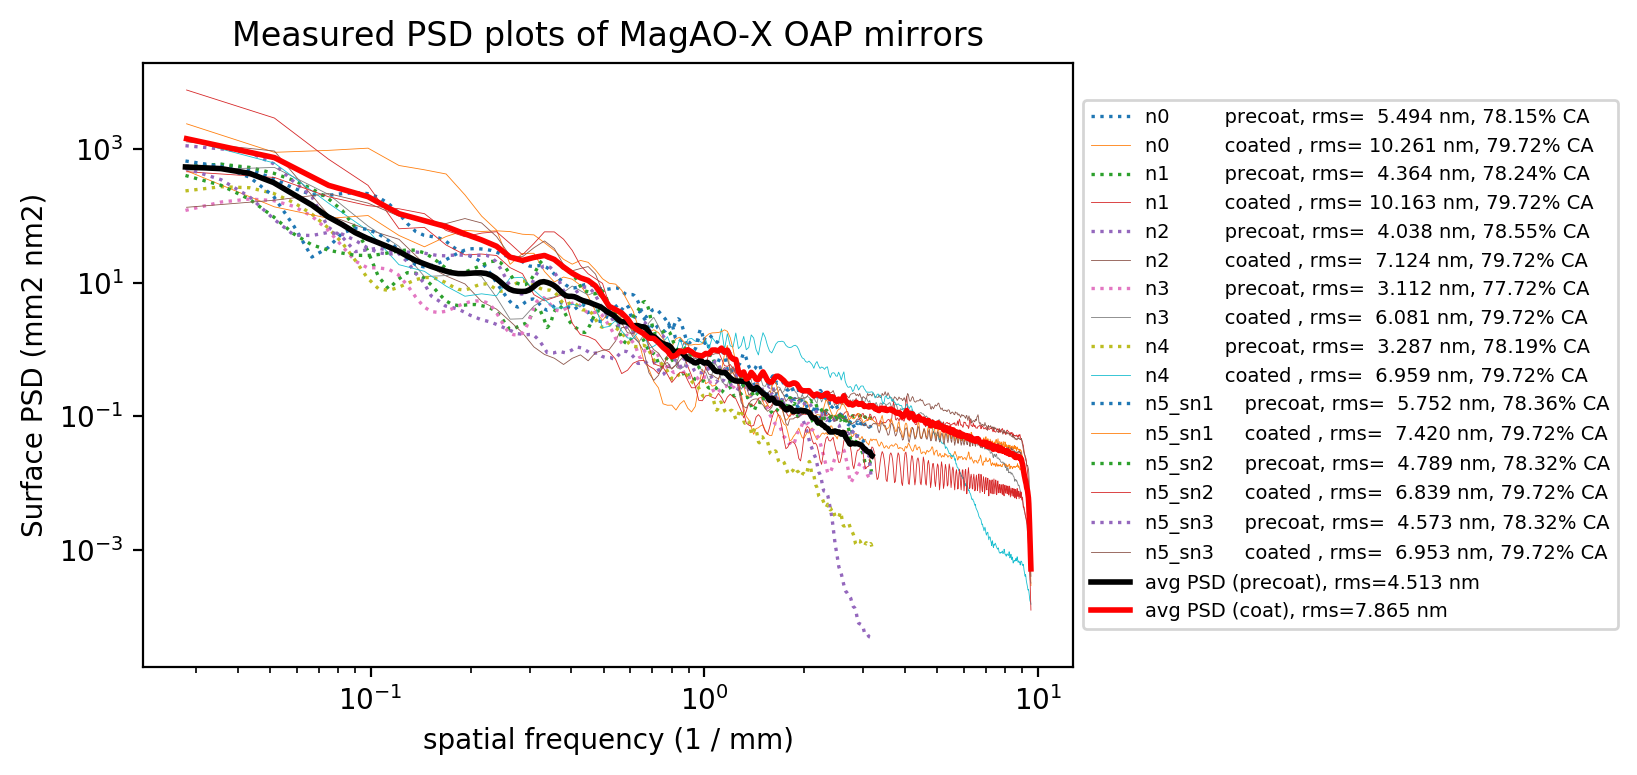

In [9]:
plt.figure(dpi=200)

# individual surfaces
for ns in range(0,ntot):
    pc_name = oap_name_pc[ns]
    plt.loglog(k_out_pc[ns,:], psd1D_data_pc[ns,:], ':', 
               label='{0:<10s} {1:<7}, rms={2:>7.3f}, {3:>4.2f}% CA'.format(pc_name, 'precoat', np.sqrt(surf_var_pc[ns]), (dca_pc[ns].value/50)*100), linewidth=1.2)
    coat_name = oap_name_coat[ns]
    plt.loglog(k_out_coat[ns,:], psd1D_data_coat[ns,:], 
               label='{0:<10s} {1:<7}, rms={2:>7.3f}, {3:>4.2f}% CA'.format(coat_name, 'coated', np.sqrt(surf_var_coat[ns]), (dca_coat[ns].value/50)*100), linewidth=0.3)

# average psd surface    
plt.loglog(k_out_pc[0,:], avg_psd1d_norm_var_pc, 'k', 
           label='avg PSD (precoat), rms={0:.3f}'.format(avg_rms_pc), linewidth=2)  
plt.loglog(k_out_coat[0,:], avg_psd1d_norm_var_coat, 'r', 
           label='avg PSD (coat), rms={0:.3f}'.format(avg_rms_coat), linewidth=2)  

# BMC2K correction band
#plt.axvline(x=k_bmc2k.value, color='blue', 
#            label='BMC2K control band', linewidth=1)
#plt.axvline(x=(1/surf_rough).value, color='green', 
#            label='1nm surf roughness', linewidth=1)
#plt.axvline(x=tweeter_BW.value, color='green', label='Tweeter bandwidth', linewidth=1)

plt.title('Measured PSD plots of MagAO-X OAP mirrors')
plt.legend(prop={'size':7},loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('spatial frequency ({0})'.format(dk_pc[0].unit))
plt.ylabel('Surface PSD ({0})'.format(psd1D_data_pc.unit)) 

Text(0, 0.5, 'Surface PSD (mm2 nm2)')

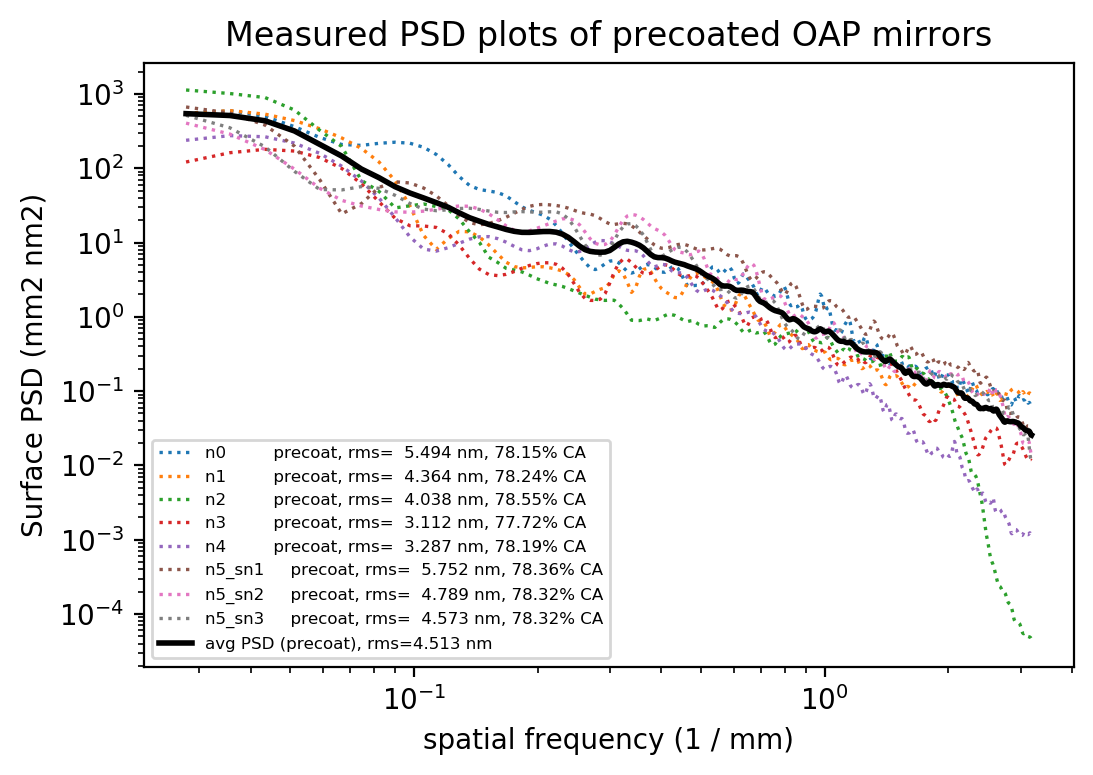

In [10]:
plt.figure(dpi=200)

# individual surfaces
for ns in range(0,ntot):
    pc_name = oap_name_pc[ns]
    plt.loglog(k_out_pc[ns,:], psd1D_data_pc[ns,:], ':', 
               label='{0:<10s} {1:<7}, rms={2:>7.3f}, {3:>4.2f}% CA'.format(pc_name, 'precoat', np.sqrt(surf_var_pc[ns]), (dca_pc[ns].value/50)*100), linewidth=1.2)
    
# average psd surface    
plt.loglog(k_out_pc[0,:], avg_psd1d_norm_var_pc, 'k', 
           label='avg PSD (precoat), rms={0:.3f}'.format(avg_rms_pc), linewidth=2)   

# BMC2K correction band
#plt.axvline(x=k_bmc2k.value, color='blue', 
#            label='BMC2K control band', linewidth=1)

plt.title('Measured PSD plots of precoated OAP mirrors')
plt.legend(prop={'size':6}, loc='lower left')
plt.xlabel('spatial frequency ({0})'.format(dk_pc[0].unit))
plt.ylabel('Surface PSD ({0})'.format(psd1D_data_pc.unit)) 

Text(0, 0.5, 'Surface PSD (mm2 nm2)')

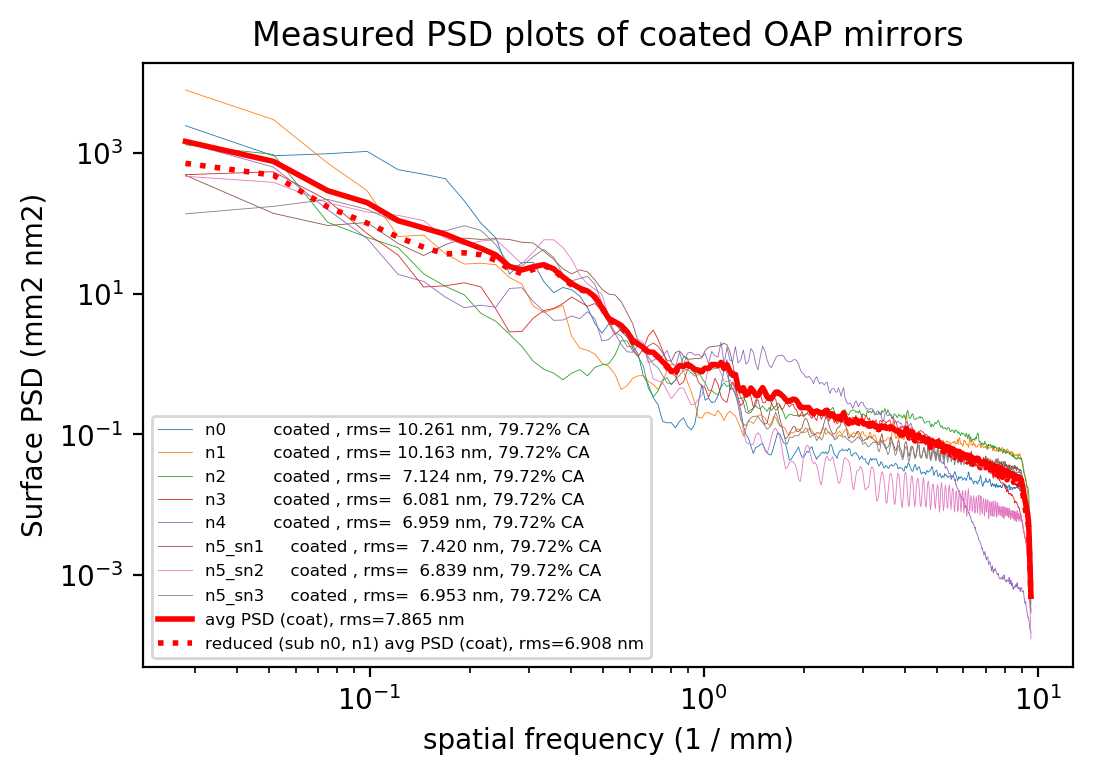

In [11]:
plt.figure(dpi=200)

# individual surfaces
for ns in range(0,ntot):
    coat_name = oap_name_coat[ns]
    plt.loglog(k_out_coat[ns,:], psd1D_data_coat[ns,:], 
               label='{0:<10s} {1:<7}, rms={2:>7.3f}, {3:>4.2f}% CA'.format(coat_name, 'coated', np.sqrt(surf_var_coat[ns]), (dca_coat[ns].value/50)*100), linewidth=0.3)

# average psd surface     
plt.loglog(k_out_coat[0,:], avg_psd1d_norm_var_coat, 'r', 
           label='avg PSD (coat), rms={0:.3f}'.format(avg_rms_coat), linewidth=2)
plt.loglog(k_out_coat[0,:], red_avg_psd1d_norm_var_coat, 'r:', 
           label='reduced (sub n0, n1) avg PSD (coat), rms={0:.3f}'.format(red_avg_rms_coat), linewidth=2)

# BMC2K correction band
#plt.axvline(x=k_bmc2k.value, color='blue', 
#            label='BMC2K control band', linewidth=1)

plt.title('Measured PSD plots of coated OAP mirrors')
plt.legend(prop={'size':6}, loc='lower left')
plt.xlabel('spatial frequency ({0})'.format(dk_coat[0].unit))
plt.ylabel('Surface PSD ({0})'.format(psd1D_data_pc.unit))

## Calculate the RMS at low, mid, high spatial frequency bands.
Verify that manufacturer met specs.

In [15]:
# Evaluate the rms at low, mid, high spatial frequency 
klow_min = 1/(40*u.mm)
klow_max = 1/(10*u.mm)
klow_rms_target = 7.5*u.nm

kmid_min = 1/(10*u.mm)
kmid_max = 1/(1*u.mm)
kmid_rms_target = 10.2*u.nm

khigh_min = 1/(1*u.mm)
khigh_max = 1/(0.085*u.mm)
khigh_rms_target = 5.2*u.nm

# variables needed for coated OAP spatial frequency
coat_parms = {'ovs': 4096,
              'npix_diam_ca': dpix_coat[0],
              'diam_ca': dca_coat[0]}
dk, freqval = psd.calc_spatialFreq(coat_parms)
shift = np.int(freqval.size/2)
rkfreq = freqval[0:shift]

# find the spatial frequency values used in the radial 1D analysis
print('spatial frequency range: low')
(bl_min, kl_min) = psd.k_locate(rkfreq, klow_min)
(bl_max, kl_max) = psd.k_locate(rkfreq, klow_max)
print('tgt | kmin: {0:>6.3f} | kmax: {1:>6.3f}'.format(klow_min, klow_max))
print('act | kmin: {0:>6.3f} | kmax: {1:>6.3f}'.format(kl_min, kl_max))
print('radial width: {0} pixels'.format(bl_max - bl_min))

print('\nspatial frequency range: mid')
(bm_min, km_min) = psd.k_locate(rkfreq, kmid_min)
(bm_max, km_max) = psd.k_locate(rkfreq, kmid_max)
print('tgt | kmin: {0:>6.3f} | kmax: {1:>6.3f}'.format(kmid_min, kmid_max))
print('act | kmin: {0:>6.3f} | kmax: {1:>6.3f}'.format(km_min, km_max))
print('radial width: {0} pixels'.format(bm_max - bm_min))

print('\nspatial frequency range: high')
(bh_min, kh_min) = psd.k_locate(rkfreq, khigh_min)
(bh_max, kh_max) = psd.k_locate(rkfreq, khigh_max)
print('tgt | kmin: {0:>6.3f} | kmax: {1:>6.3f}'.format(khigh_min, khigh_max))
print('act | kmin: {0:>6.3f} | kmax: {1:>6.3f}'.format(kh_min, kh_max))
print('radial width: {0} pixels'.format(bh_max - bh_min))

print('\nRMS calculations')
print('{0:>7} | {1:^9.4} | {2:^10.4} | {3:^9.4}'.format('optic', 'low', 'mid', 'high'))
print('{0:>7} | {1:.4f} | {2:2.4f} | {3:.4f}'.format('tgt', klow_rms_target, kmid_rms_target, khigh_rms_target))

klrms = []
kmrms = []
khrms = []
for no in range(0, ntot):
    oap_name = oap_name_coat[no]
    t_psd2D = psd2d_norm_coat[oap_name] * surf_var_coat[no]
    
    (kl, lmask) = psd.calc_psd_rms(t_psd2D, freqval, [bl_min, bl_max])
    (km, mmask) = psd.calc_psd_rms(t_psd2D, freqval, [bm_min, bm_max])
    (kh, hmask) = psd.calc_psd_rms(t_psd2D, freqval, [bh_min, bh_max])
    
    print('{0:>7} | {1:.4f} | {2:7.4f} | {3:.4f}'.format(oap_name, kl, km, kh))
    
    klrms.append(kl)
    kmrms.append(km)
    khrms.append(kh)


spatial frequency range: low
tgt | kmin:  0.025 1 / mm | kmax:  0.100 1 / mm
act | kmin:  0.023 1 / mm | kmax:  0.098 1 / mm
radial width: 16 pixels

spatial frequency range: mid
tgt | kmin:  0.100 1 / mm | kmax:  1.000 1 / mm
act | kmin:  0.098 1 / mm | kmax:  1.001 1 / mm
radial width: 193 pixels

spatial frequency range: high
tgt | kmin:  1.000 1 / mm | kmax: 11.765 1 / mm
act | kmin:  1.001 1 / mm | kmax:  9.579 1 / mm
radial width: 1833 pixels

RMS calculations
  optic |    low    |    mid     |   high   
    tgt | 7.5000 nm | 10.2000 nm | 5.2000 nm
     n0 | 5.7777 nm |  7.8189 nm | 2.8146 nm
     n1 | 7.9845 nm |  3.4592 nm | 4.4178 nm
     n2 | 3.7554 nm |  2.3411 nm | 5.3397 nm
     n3 | 2.9967 nm |  3.1623 nm | 4.1974 nm
     n4 | 3.5258 nm |  2.9501 nm | 5.0626 nm
 n5_sn1 | 2.1287 nm |  5.7195 nm | 4.1451 nm
 n5_sn2 | 2.7982 nm |  5.7845 nm | 2.2516 nm
 n5_sn3 | 2.3126 nm |  5.4236 nm | 3.6668 nm


In [17]:
mid_rms = np.mean((kmrms * u.nm).value)
mid_var = mid_rms**2

In [16]:
tot_mask = (lmask.astype(np.int))+(mmask.astype(np.int)*2)+(hmask.astype(np.int)*3)

plt.figure(dpi=100)
plt.imshow(tot_mask, origin='lower')
#plt.colorbar()
plt.title('spatial frequency mask')
plt.close()

## Linearizing the PSD data

In [8]:
k_range = k_out_coat[0,:]
alpha_pdr = 1.55 # estimate for OAP
beta_pdr = psd.calc_beta(alpha_pdr, avg_var_coat, opt_parms['diam_ca'], dpix_coat[0])
#a2_fit = b2/(k_range**a2)
#a2_fit1 = b2/((avg_var_coat**a2)*(k_range**a2))

y = np.log10(avg_psd1d_norm_var_coat.value)
x = np.log10(k_range)
rhs = ((alpha_pdr*-1)*(x)) + np.log10(beta_pdr.value)

# let's try linear least square fit
A = np.vstack([x, np.ones(len(x))]).T
m,c = np.linalg.lstsq(A, y)[0]
alpha_lsf = -1*m
beta_lsf = 10**(c)
nrhs = m*x + c

# but does it produce a different beta for this solved alpha?
beta_lsf_new = psd.calc_beta(alpha_lsf, avg_var_coat, opt_parms['diam_ca'], dpix_coat[0])
#na2_fit = nb2/(k_range**(-m))
nrhs2 = (m*(x)) + np.log10(beta_lsf_new.value)
print(alpha_lsf,beta_lsf,beta_lsf_new.value)

1.914171832543697 1.283895951901188 1.7415244609317186


/home/jhen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  del sys.path[0]


Text(0.5, 1.0, 'Trying to linearize the PSD data (coated surfaces)')

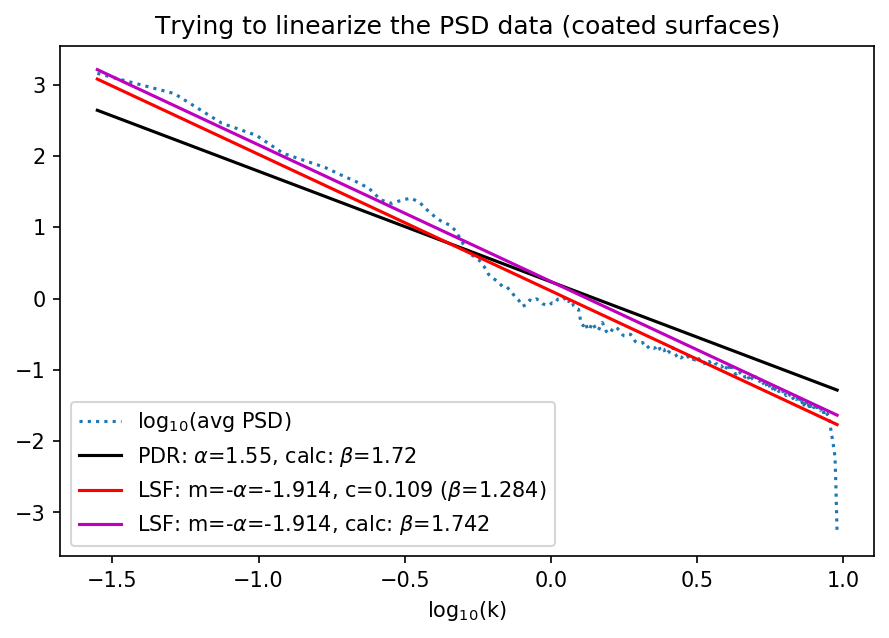

In [11]:
plt.figure(figsize=[7,4.5], dpi=150)
plt.plot(x, y, ':', label='log{0}(avg PSD)'.format(r'$_{10}$'))
plt.plot(x, rhs, 'k', 
         #label='[-({0}={1}) log{2}(k)] + log{2}({3}={4:.2f})'.format(r'$\alpha$', a2, r'$_{10}$', r'$\beta$', b2))
         label='PDR: {0}={1}, calc: {2}={3:.2f}'.format(r'$\alpha$', alpha_pdr, r'$\beta$', beta_pdr.value))
plt.plot(x, nrhs, 'r', #label='leastsqft', 
         label='LSF: m=-{0}={1:.3f}, c={2:.3f} ({3}={4:.3f})'.format(r'$\alpha$', m, c, r'$\beta$', beta_lsf))
plt.plot(x, nrhs2, 'm', #label='leastsqft', 
         label='LSF: m=-{0}={1:.3f}, calc: {2}={3:.3f}'.format(r'$\alpha$', m, r'$\beta$', beta_lsf_new.value))
plt.xlabel('log{0}(k)'.format(r'$_{10}$'))
#plt.ylabel('log{0}(PSD)'.format(r'$_{10}$'))
plt.legend()
plt.title('Trying to linearize the PSD data (coated surfaces)')

/home/jhen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


Text(0.5, 1.0, 'Full PSD, high-k cut-off')

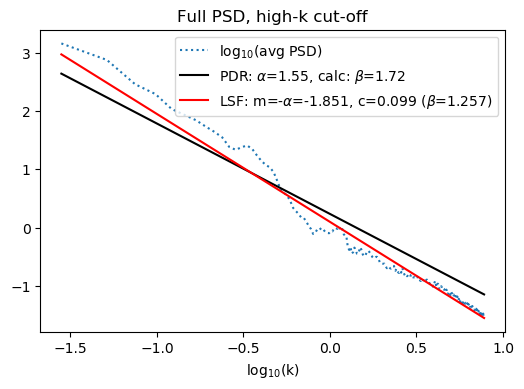

In [12]:
ny = y[np.where(y>-1.5)]
nx = x[0:len(ny)]
rhs_pdr = ((alpha_pdr*-1)*(nx)) + np.log10(beta_pdr.value)
#nrhs = ((a2*-1)*(nx)) + np.log10(b2.value)
# let's try linear least square fit
nA = np.vstack([nx, np.ones(len(nx))]).T
nm,nc = np.linalg.lstsq(nA, ny)[0]
nalpha_lsf = -1*nm
nbeta_lsf = 10**(nc)
nnrhs = nm*nx + nc
plt.figure(dpi=100)
plt.plot(nx, ny, ':', label='log{0}(avg PSD)'.format(r'$_{10}$'))
plt.plot(nx, rhs_pdr, 'k', 
         #label='[-({0}={1}) log{2}(k)] + log{2}({3}={4:.2f})'.format(r'$\alpha$', a2, r'$_{10}$', r'$\beta$', b2))
         label='PDR: {0}={1}, calc: {2}={3:.2f}'.format(r'$\alpha$', alpha_pdr, r'$\beta$', beta_pdr.value))
plt.plot(nx, nnrhs, 'r', #label='leastsqft', 
         label='LSF: m=-{0}={1:.3f}, c={2:.3f} ({3}={4:.3f})'.format(r'$\alpha$', nm, nc, r'$\beta$', nbeta_lsf))
plt.legend()
plt.xlabel('log{0}(k)'.format(r'$_{10}$'))
plt.title('Full PSD, high-k cut-off')

In [18]:
# set the limits
kmid_min = 0.1
kmid_max = 1.0
kmid_coords = np.intersect1d(np.where(k_range<kmid_max),np.where(k_range>kmid_min))

# select only regions that matter
kmid_range = k_range[kmid_coords]
psd_mid_range = avg_psd1d_norm_var_coat[kmid_coords].value

# set to log scale
ymid = np.log10(psd_mid_range)
xmid = np.log10(kmid_range)

# model for mid-range spatial frequencies
rhs_mid = ((alpha_pdr*-1)*(xmid)) + np.log10(beta_pdr.value)

# Linear LSF calculation for mid-range spatial frequencies
A_mid = np.vstack([xmid, np.ones(len(xmid))]).T
m_mid, c_mid = np.linalg.lstsq(A_mid, ymid)[0]
alpha_mid = -1*m_mid
beta_mid= 10**(c_mid)
nrhs_mid = m_mid*xmid + c_mid

# what with the different beta?
beta_mid_new = psd.calc_beta(alpha_mid, mid_var, opt_parms['diam_ca'], dpix_coat[0])
nrhs_mid_2 = (m_mid*(xmid)) + np.log10(beta_lsf_new.value)

# calculate the model using total alpha and beta
nrhs_tot = m*xmid + c
nrhs_tot_2 = m*xmid + np.log10(beta_lsf_new.value)

#kmid_range = k_range[np.where(k_range>kmid_min) and np.where(k_range<kmid_max)]
#kmid_range

/home/jhen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Text(0.5, 1.0, 'Linearizing the PSD data (coated surfaces, mid-range spatial frequencies)')

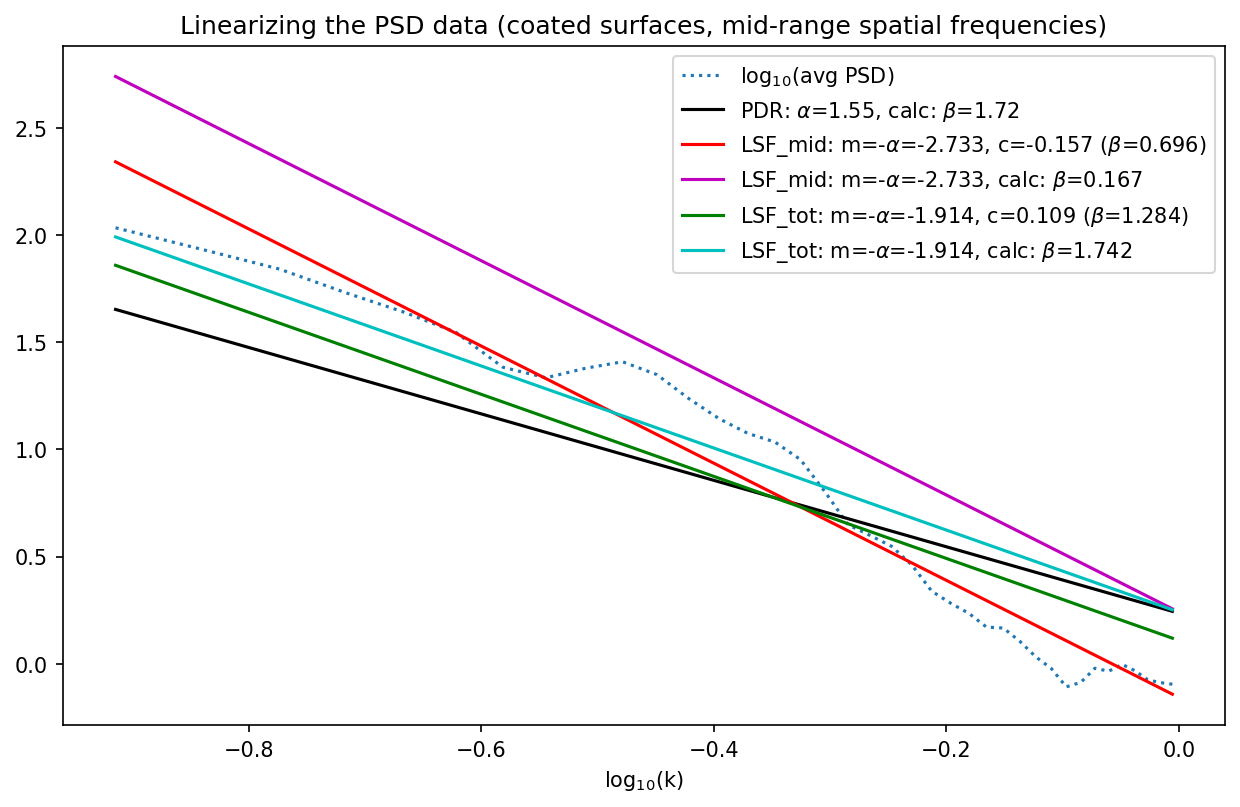

In [19]:
plt.figure(figsize=[10,6], dpi=150)
plt.plot(xmid, ymid, ':', label='log{0}(avg PSD)'.format(r'$_{10}$'))
plt.plot(xmid, rhs_mid, 'k', 
         #label='[-({0}={1}) log{2}(k)] + log{2}({3}={4:.2f})'.format(r'$\alpha$', a2, r'$_{10}$', r'$\beta$', b2))
         label='PDR: {0}={1}, calc: {2}={3:.2f}'.format(r'$\alpha$', alpha_pdr, r'$\beta$', beta_pdr.value))
plt.plot(xmid, nrhs_mid, 'r', #label='leastsqft', 
         label='LSF_mid: m=-{0}={1:.3f}, c={2:.3f} ({3}={4:.3f})'.format(r'$\alpha$', m_mid, c_mid, r'$\beta$', beta_mid))
plt.plot(xmid, nrhs_mid_2, 'm', #label='leastsqft', 
         label='LSF_mid: m=-{0}={1:.3f}, calc: {2}={3:.3f}'.format(r'$\alpha$', m_mid, r'$\beta$', beta_mid_new.value))
plt.plot(xmid, nrhs_tot, 'g', #label='leastsqft', 
         label='LSF_tot: m=-{0}={1:.3f}, c={2:.3f} ({3}={4:.3f})'.format(r'$\alpha$', m, c, r'$\beta$', beta_lsf))
plt.plot(xmid, nrhs_tot_2, 'c', #label='leastsqft', 
         label='LSF_tot: m=-{0}={1:.3f}, calc: {2}={3:.3f}'.format(r'$\alpha$', m, r'$\beta$', beta_lsf_new.value))

plt.xlabel('log{0}(k)'.format(r'$_{10}$'))
#plt.ylabel('log{0}(PSD)'.format(r'$_{10}$'))
plt.legend()
plt.title('Linearizing the PSD data (coated surfaces, mid-range spatial frequencies)')

In [67]:
10**(c)

1.883613424210864

## Modelling the PSD
Finding alpha, beta, l0, L0

In [23]:
np.mean(dpix_coat)

764.0

In [47]:
# alpha and beta should be fit on the mid-spatial frequency content region
# choose the cut-off for position
#klim = 0.15
klim = np.amin(k_out_coat[0])
k_npts = k_out_coat[0].shape[0]
kfit = np.zeros((k_npts))
for kn in range(0,k_npts):
    kfit[kn] = np.abs(k_out_coat[0][kn] - klim)
klim_ind = np.argmin(kfit)
k_range = k_out_coat[0,klim_ind:k_npts]
avg_npix_diam = np.int(np.mean(dpix_coat))

a2 = 1.55 # estimate for OAP
b2 = psd.calc_beta(a2, avg_var_coat, opt_parms['diam_ca'], avg_npix_diam)
a2_fit = b2/(k_range**a2)
a2_fit1 = b2/((avg_var_coat**a2)*(k_range**a2))

k_ul = 1/(2*opt_parms['diam_ca']/opt_parms['npix_diam_ca'])
k_far = np.linspace(klim, k_ul.value+0, k_npts+100)
L0 = 15 # psd value
lo = 0.1
psd_full = b2 * np.exp(-(k_far*lo)**2) / ( ( (L0**-2) + (k_far**2) ) ** (a2*.5))
psd_fit = (b2/(k_far**a2)) * np.exp(-(k_far * lo)**2)

In [ ]:
plt.plot(x, nrhs, 'r', #label='leastsqft', 
         label='LSF: m=-{0}={1:.3f}, c={2:.3f} ({3}={4:.3f})'.format(r'$\alpha$', m, c, r'$\beta$', beta_lsf))

Text(0, 0.5, 'Surface PSD (mm2 nm2)')

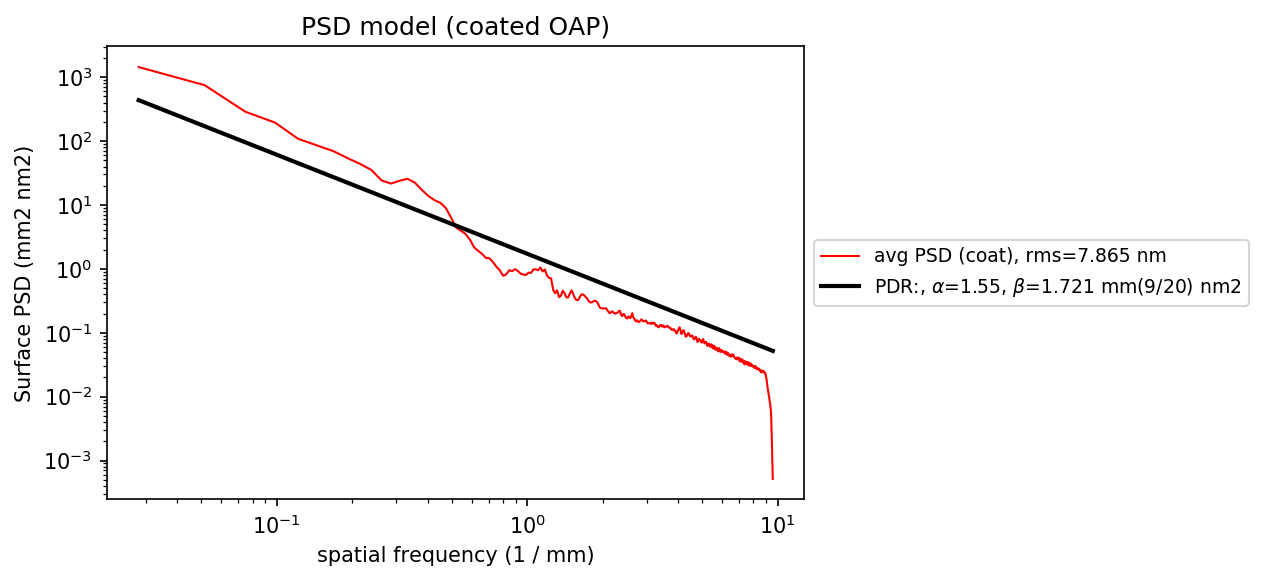

In [50]:
# plotting
plt.figure(dpi=150)

# individual surfaces
#for ns in range(0,ntot):
#    coat_name = oap_name_coat[ns]
#    plt.loglog(k_out_coat[ns,:], psd1D_data_coat[ns,:], 
#               label='{0:<10s} {1:<7}, rms={2:>7.3f}, {3:>4.2f}% CA'.format(coat_name, 'coated', np.sqrt(surf_var_coat[ns]), (dca_coat[ns].value/50)*100), linewidth=0.3)

# average psd surface    
plt.loglog(k_out_coat[0,:], avg_psd1d_norm_var_coat, 'r', 
           label='avg PSD (coat), rms={0:.3f}'.format(avg_rms_coat), linewidth=1)  
#for ns in range(0,ntot):
#   opt_name = oap_name_coat[ns]
#   plt.loglog(k_out_coat[ns], new_psd_data[ns,:], ':', label='{}, rms={:.3f}'.format(opt_name, np.sqrt(var_1[opt_name])), linewidth=1.0)
#plt.loglog(k_new, avg_psd_data, 'k--', label='avg PSD data')
#plt.loglog(k_out_coat[0], avg_psd_norm, 'k', label='Avg PSD, rms={:.3f}'.format(avg_tot_rms)) 
#plt.loglog(k_new, alpha_fit, label='alpha={}'.format(alpha))
#plt.loglog(k_new, a2_fit, label='{} model fit'.format(r'$\frac{$\beta$}{k^{$\alpha$}}$'))
plt.loglog(k_out_coat[0], a2_fit, 'k', 
           #label='{} model, {}={}, {}={:.3f}'.format(r'$\frac{\beta}{k^{\alpha}}$', r'$\alpha$',a2, r'$\beta$',b2), 
           label='PDR:, {}={}, {}={:.3f}'.format(r'$\alpha$',a2, r'$\beta$',b2), 
           linewidth=2.0)
#plt.loglog(k_range, a2_fit1, 'g', label='{} model fit'.format(r'$\frac{\beta}{(var_{avg} k)^{\alpha}}$', linewidth=2.0))
#plt.title('Measured PSD of coated OAP mirrors (D={0:.3f}, {1}% CA of 80% CA of full)'.format(opt_parms['diam_ca'], opt_parms['ca']))
plt.title('PSD model (coated OAP)')
plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('spatial frequency ({0})'.format(dk_coat[0].unit))
plt.ylabel('Surface PSD ({})'.format(psd1D_data_coat.unit)) 

Text(0, 0.5, 'Surface PSD (mm2 nm2)')

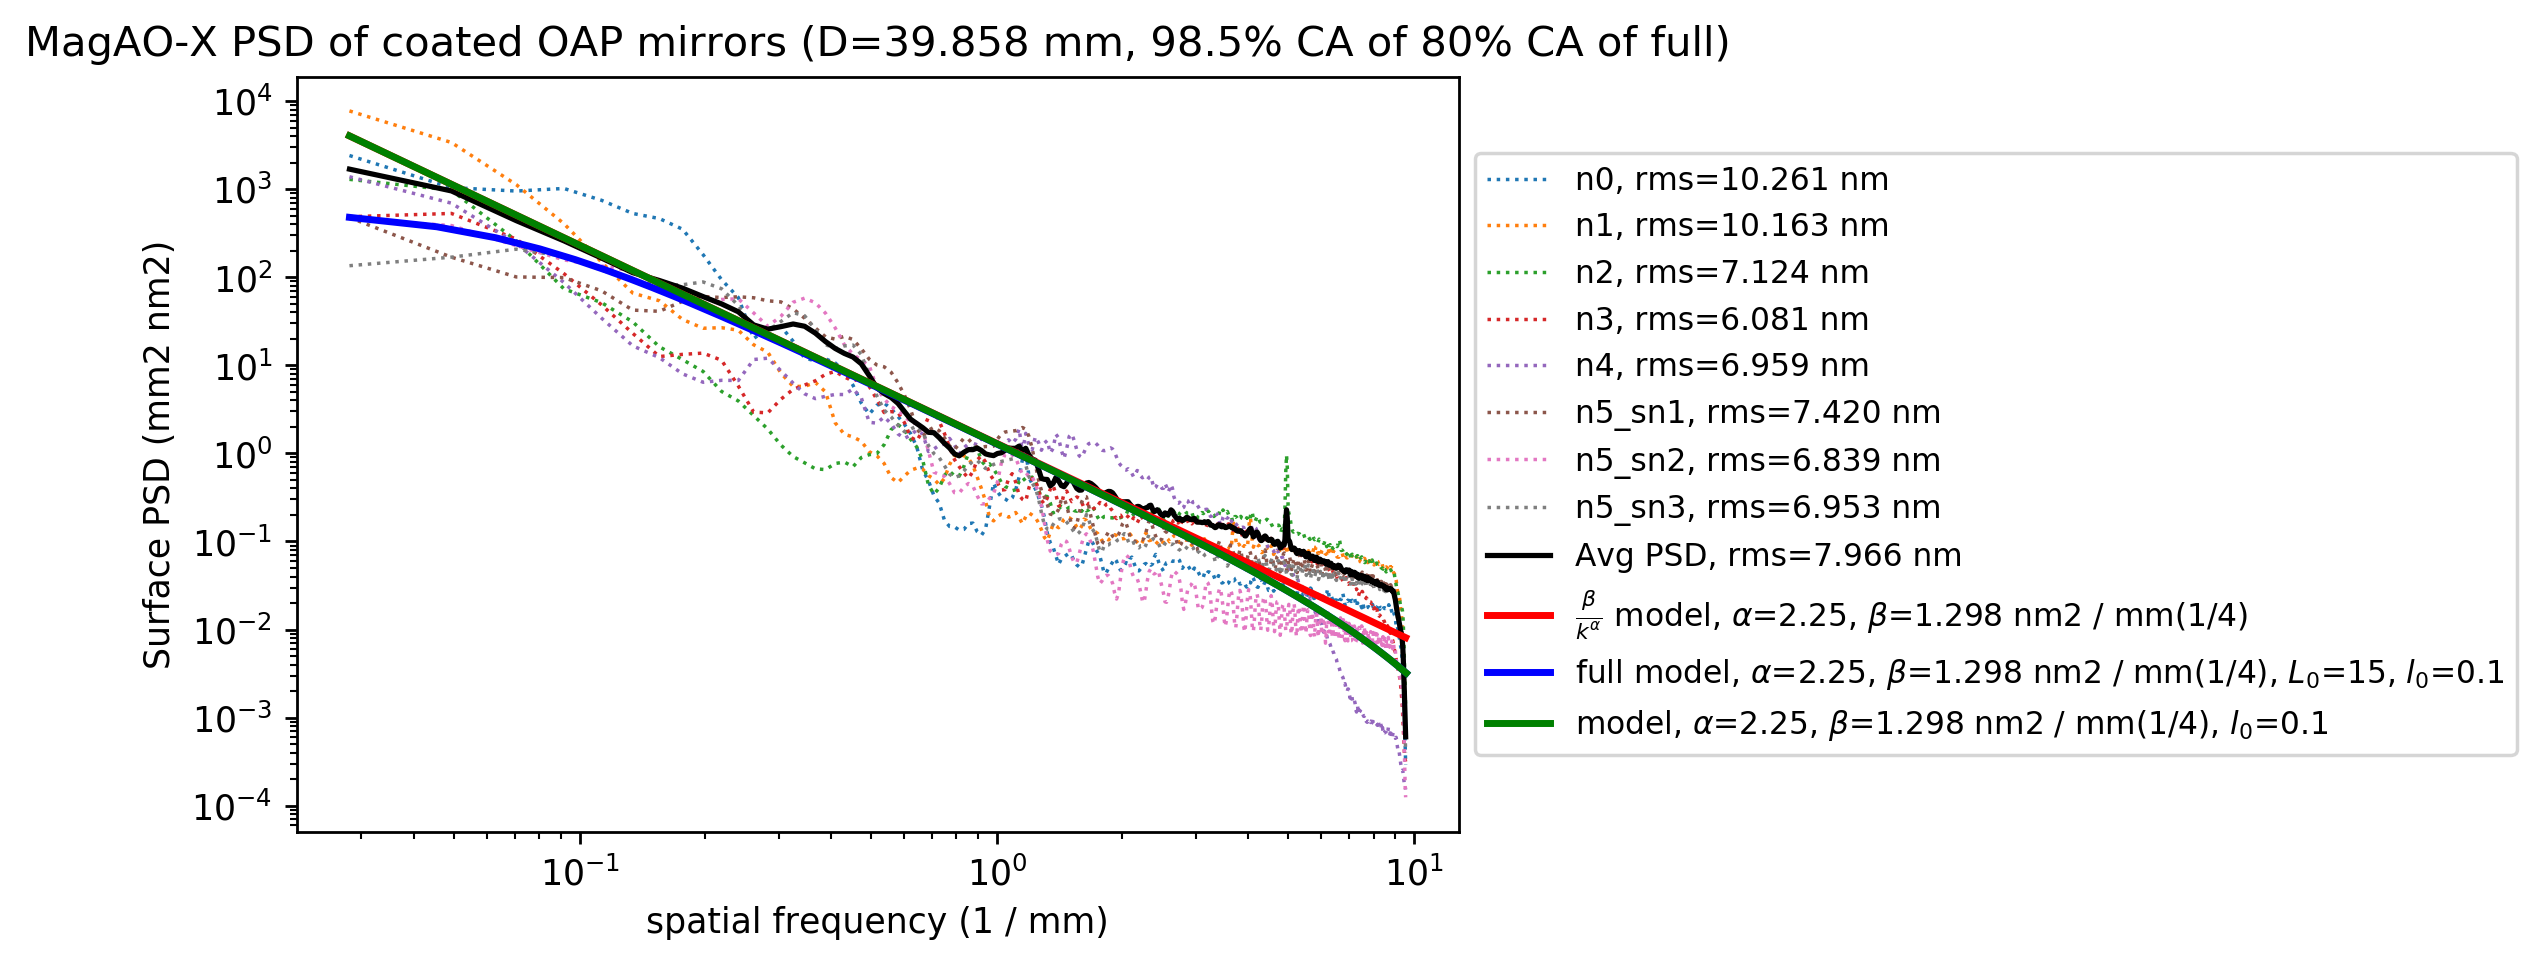

In [254]:
# plotting
plt.figure(dpi=250)
for ns in range(0,ntot):
   name = n_oap_list[ns]
   plt.loglog(k_new, new_psd_data[ns,:], ':', label='{}, rms={:.3f}'.format(name, np.sqrt(var_1[name])), linewidth=1.0)
#plt.loglog(k_new, avg_psd_data, 'k--', label='avg PSD data')
plt.loglog(k_new, avg_psd_norm, 'k', label='Avg PSD, rms={:.3f}'.format(avg_tot_rms)) 
#plt.loglog(k_new, alpha_fit, label='alpha={}'.format(alpha))
#plt.loglog(k_new, a2_fit, label='{} model fit'.format(r'$\frac{$\beta$}{k^{$\alpha$}}$'))
#plt.loglog(k_range, a2_fit, 'r', label='{} model, {}={}'.format(r'$\frac{\beta}{k^{\alpha}}$', r'$\alpha$',a2), linewidth=2.0)
#plt.loglog(k_range, a2_fit1, 'g', label='{} model fit'.format(r'$\frac{\beta}{(var_{avg} k)^{\alpha}}$', linewidth=2.0))
plt.loglog(k_range, a2_fit, 'r', label='{} model, {}={}, {}={:.3f}'.format(r'$\frac{\beta}{k^{\alpha}}$', r'$\alpha$',a2, r'$\beta$',b2), linewidth=2.0)
plt.loglog(k_far, psd_full, 'b', label='full model, {}={}, {}={:.3f}, {}={}, {}={}'.format(r'$\alpha$',a2,r'$\beta$',b2, r'$L_{0}$',L0, r'$l_{0}$', lo), linewidth=2.0)
plt.loglog(k_far, psd_fit, 'g', label='model, {}={}, {}={:.3f}, {}={}'.format(r'$\alpha$',a2,r'$\beta$',b2, r'$l_{0}$', lo), linewidth=2.0)
plt.title('MagAO-X PSD of coated OAP mirrors (D={0:.3f}, {1}% CA of 80% CA of full)'.format(opt_parms['diam_ca'], opt_parms['ca']))
plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('spatial frequency ({})'.format(k_new.unit))
plt.ylabel('Surface PSD ({})'.format(new_psd_data.unit)) 

Text(0, 0.5, 'Surface PSD (mm2 nm2)')

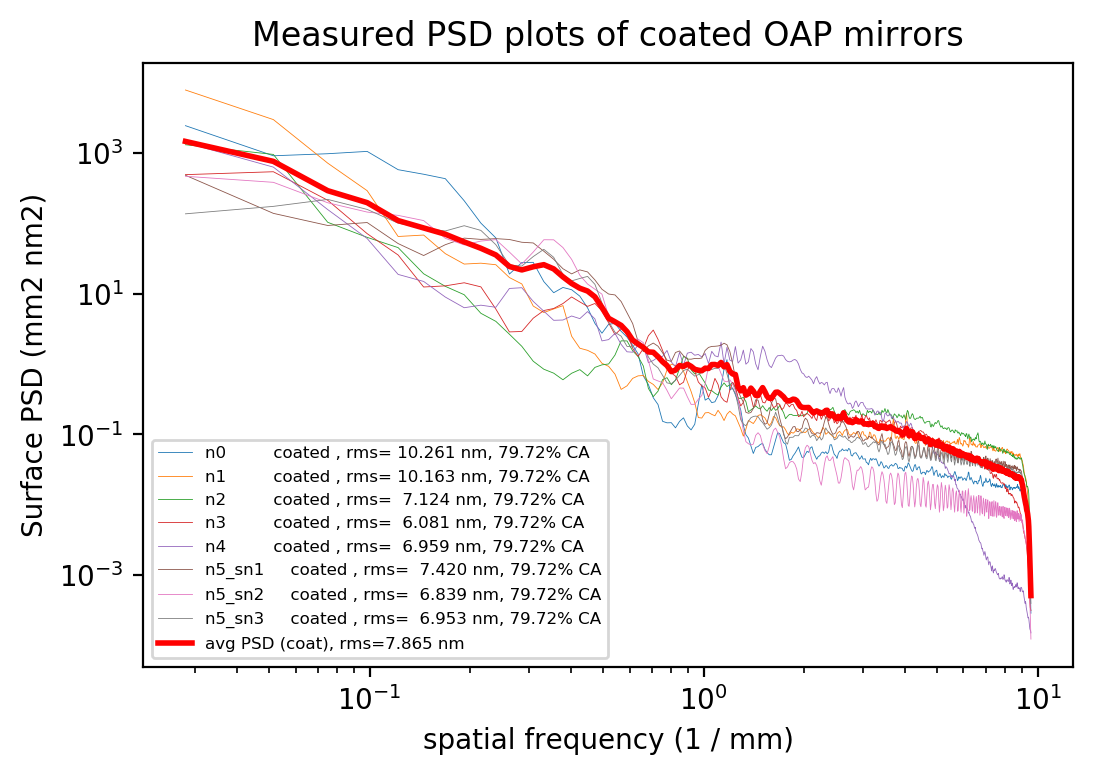

In [25]:
plt.figure(dpi=200)

# individual surfaces
for ns in range(0,ntot):
    coat_name = oap_name_coat[ns]
    plt.loglog(k_out_coat[ns,:], psd1D_data_coat[ns,:], label='{0:<10s} {1:<7}, rms={2:>7.3f}, {3:>4.2f}% CA'.format(coat_name, 'coated', np.sqrt(surf_var_coat[ns]), (dca_coat[ns].value/50)*100), linewidth=0.3)

# average psd surface     
plt.loglog(k_out_coat[0,:], avg_psd1d_norm_var_coat, 'r', label='avg PSD (coat), rms={0:.3f}'.format(avg_rms_coat), linewidth=2)  

plt.title('Measured PSD plots of coated OAP mirrors')
plt.legend(prop={'size':6}, loc='lower left')
plt.xlabel('spatial frequency ({0})'.format(dk_coat[0].unit))
plt.ylabel('Surface PSD ({0})'.format(psd1D_data_pc.unit))

Text(0, 0.5, 'Surface PSD (mm2 nm2)')

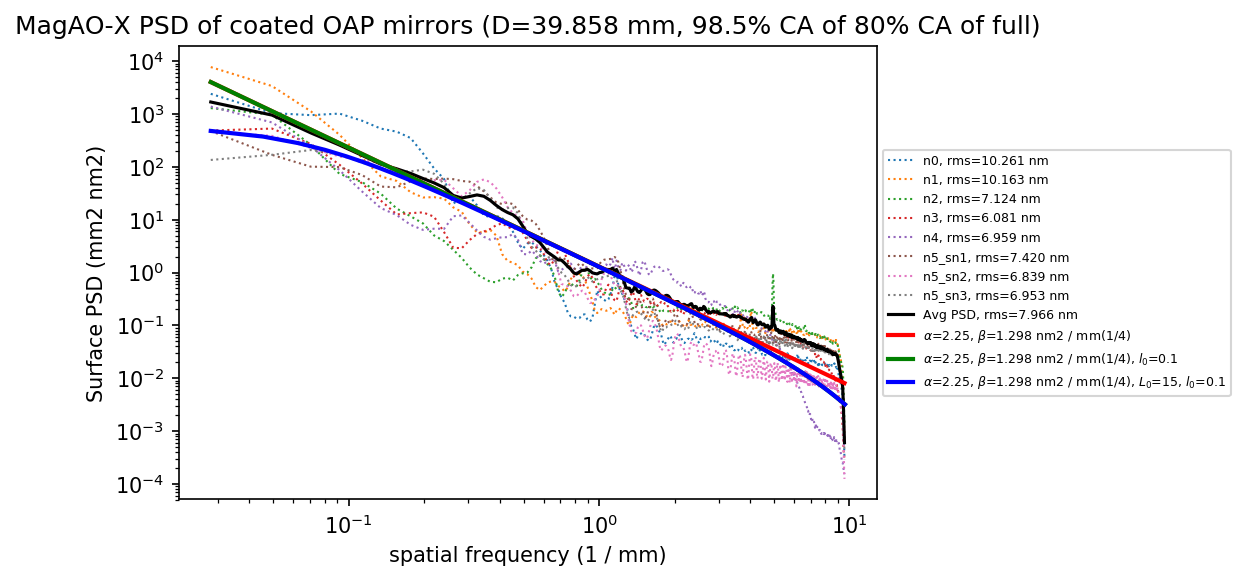

In [258]:
# plotting
plt.figure(dpi=150)
for ns in range(0,ntot):
   name = n_oap_list[ns]
   plt.loglog(k_new, new_psd_data[ns,:], ':', label='{}, rms={:.3f}'.format(name, np.sqrt(var_1[name])), linewidth=1.0)
#plt.loglog(k_new, avg_psd_data, 'k--', label='avg PSD data')
plt.loglog(k_new, avg_psd_norm, 'k', label='Avg PSD, rms={:.3f}'.format(avg_tot_rms)) 
#plt.loglog(k_new, alpha_fit, label='alpha={}'.format(alpha))
#plt.loglog(k_new, a2_fit, label='{} model fit'.format(r'$\frac{$\beta$}{k^{$\alpha$}}$'))
#plt.loglog(k_range, a2_fit, 'r', label='{} model, {}={}'.format(r'$\frac{\beta}{k^{\alpha}}$', r'$\alpha$',a2), linewidth=2.0)
#plt.loglog(k_range, a2_fit1, 'g', label='{} model fit'.format(r'$\frac{\beta}{(var_{avg} k)^{\alpha}}$', linewidth=2.0))
plt.loglog(k_range, a2_fit, 'r', label='{}={}, {}={:.3f}'.format(r'$\alpha$',a2, r'$\beta$',b2), linewidth=2.0)
plt.loglog(k_far, psd_fit, 'g', label='{}={}, {}={:.3f}, {}={}'.format(r'$\alpha$',a2,r'$\beta$',b2, r'$l_{0}$', lo), linewidth=2.0)
plt.loglog(k_far, psd_full, 'b', label='{}={}, {}={:.3f}, {}={}, {}={}'.format(r'$\alpha$',a2,r'$\beta$',b2, r'$L_{0}$',L0, r'$l_{0}$', lo), linewidth=2.0)
plt.title('MagAO-X PSD of coated OAP mirrors (D={0:.3f}, {1}% CA of 80% CA of full)'.format(opt_parms['diam_ca'], opt_parms['ca']))
plt.legend(prop={'size':6},loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('spatial frequency ({})'.format(k_new.unit))
plt.ylabel('Surface PSD ({})'.format(new_psd_data.unit)) 

Text(0, 0.5, 'Surface PSD (mm2 nm2)')

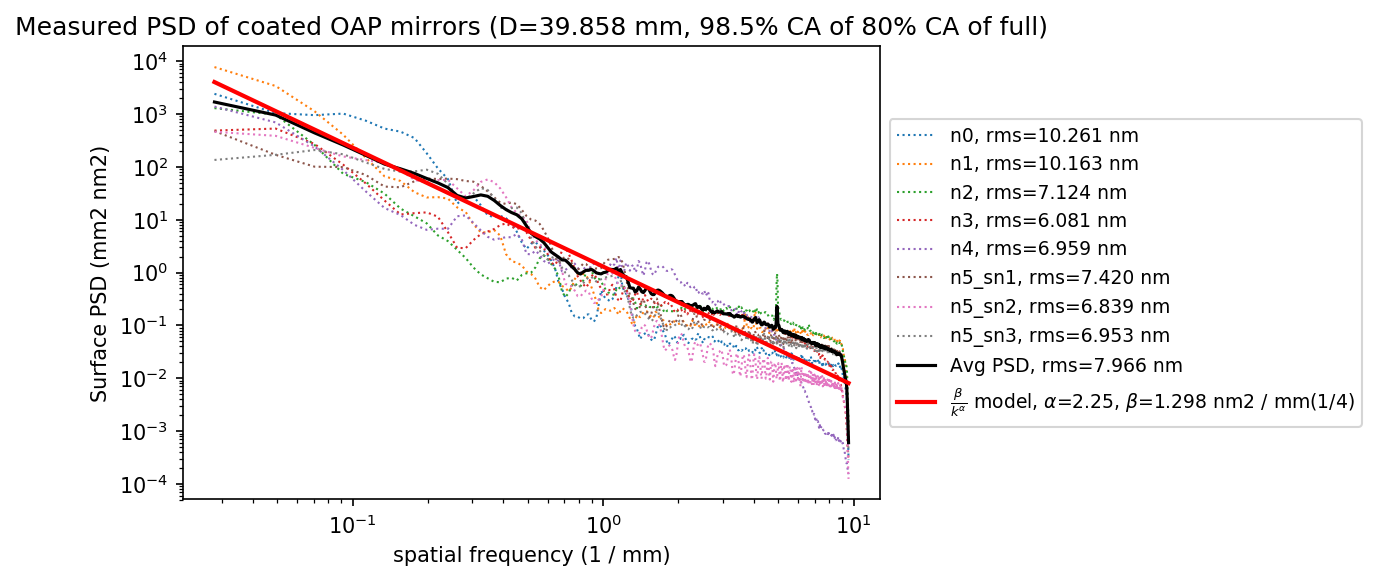

In [243]:
# alpha and beta should be fit on the mid-spatial frequency content region
# choose the cut-off for position
#klim = 0.15
klim = np.amin(k_new.value)
kfit = np.zeros((k_npts))
for kn in range(0,k_npts):
    kfit[kn] = np.abs(k_new[kn].value - klim)
klim_ind = np.argmin(kfit)
k_range = k_new[klim_ind:k_npts]

a2 = 2.25 # estimate for OAP
b2 = psd.calc_beta(a2, avg_tot_var, opt_parms['diam_ca'], avg_npix_diam)
a2_fit = b2/(k_range**a2)
a2_fit1 = b2/((avg_tot_var**a2)*(k_range**a2))

# plotting
plt.figure(dpi=150)
for ns in range(0,ntot):
   opt_name = n_oap_list[ns]
   plt.loglog(k_new, new_psd_data[ns,:], ':', label='{}, rms={:.3f}'.format(opt_name, np.sqrt(var_1[opt_name])), linewidth=1.0)
#plt.loglog(k_new, avg_psd_data, 'k--', label='avg PSD data')
plt.loglog(k_new, avg_psd_norm, 'k', label='Avg PSD, rms={:.3f}'.format(avg_tot_rms)) 
#plt.loglog(k_new, alpha_fit, label='alpha={}'.format(alpha))
#plt.loglog(k_new, a2_fit, label='{} model fit'.format(r'$\frac{$\beta$}{k^{$\alpha$}}$'))
plt.loglog(k_range, a2_fit, 'r', label='{} model, {}={}, {}={:.3f}'.format(r'$\frac{\beta}{k^{\alpha}}$', r'$\alpha$',a2, r'$\beta$',b2), linewidth=2.0)
#plt.loglog(k_range, a2_fit1, 'g', label='{} model fit'.format(r'$\frac{\beta}{(var_{avg} k)^{\alpha}}$', linewidth=2.0))
plt.title('Measured PSD of coated OAP mirrors (D={0:.3f}, {1}% CA of 80% CA of full)'.format(opt_parms['diam_ca'], opt_parms['ca']))
plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('spatial frequency ({})'.format(k_new.unit))
plt.ylabel('Surface PSD ({})'.format(new_psd_data.unit)) 

Text(0, 0.5, 'Surface PSD (mm2 nm2)')

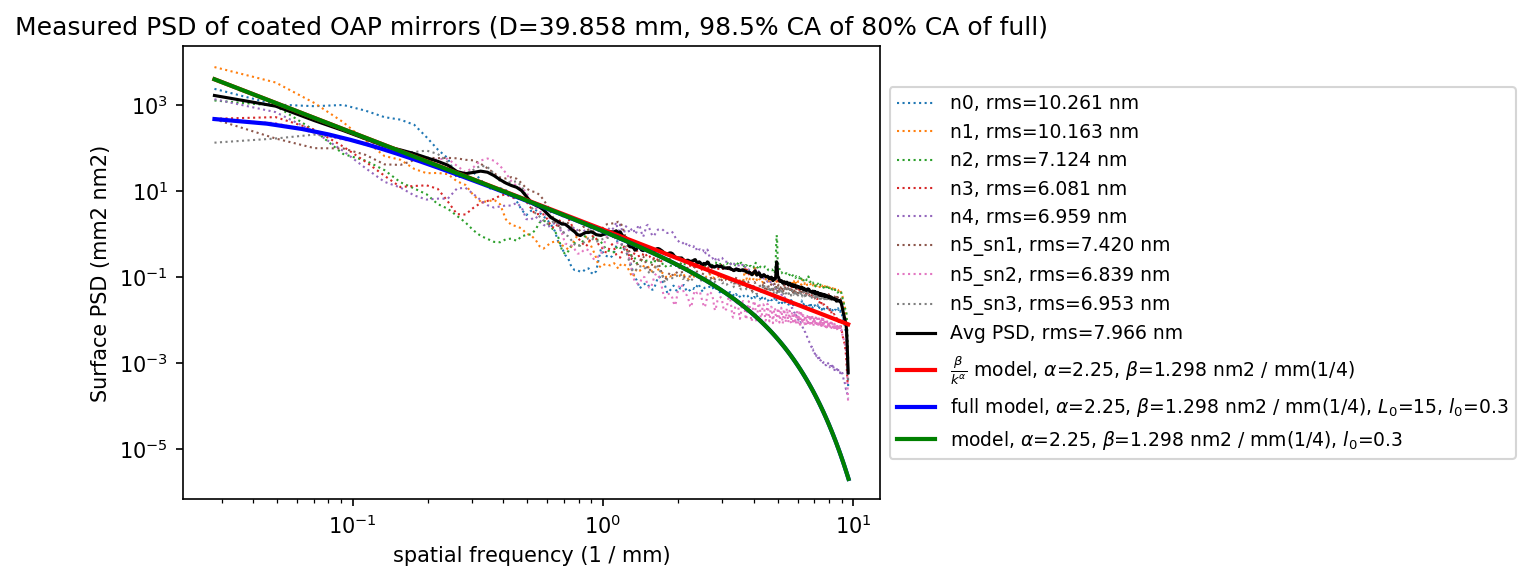

In [246]:
k_ul = 1/(2*opt_parms['diam_ca']/opt_parms['npix_diam_ca'])
k_far = np.linspace(klim, k_ul.value+0, k_npts+100)
L0 = 15
lo = 0.3
psd_full = b2 * np.exp(-(k_far*lo)**2) / ( ( (L0**-2) + (k_far**2) ) ** (a2*.5))
psd_fit = (b2/(k_far**a2)) * np.exp(-(k_far * lo)**2)

# plotting
plt.figure(dpi=150)
for ns in range(0,ntot):
   name = n_oap_list[ns]
   plt.loglog(k_new, new_psd_data[ns,:], ':', label='{}, rms={:.3f}'.format(name, np.sqrt(var_1[name])), linewidth=1.0)
#plt.loglog(k_new, avg_psd_data, 'k--', label='avg PSD data')
plt.loglog(k_new, avg_psd_norm, 'k', label='Avg PSD, rms={:.3f}'.format(avg_tot_rms)) 
#plt.loglog(k_new, alpha_fit, label='alpha={}'.format(alpha))
#plt.loglog(k_new, a2_fit, label='{} model fit'.format(r'$\frac{$\beta$}{k^{$\alpha$}}$'))
#plt.loglog(k_range, a2_fit, 'r', label='{} model, {}={}'.format(r'$\frac{\beta}{k^{\alpha}}$', r'$\alpha$',a2), linewidth=2.0)
#plt.loglog(k_range, a2_fit1, 'g', label='{} model fit'.format(r'$\frac{\beta}{(var_{avg} k)^{\alpha}}$', linewidth=2.0))
plt.loglog(k_range, a2_fit, 'r', label='{} model, {}={}, {}={:.3f}'.format(r'$\frac{\beta}{k^{\alpha}}$', r'$\alpha$',a2, r'$\beta$',b2), linewidth=2.0)
plt.loglog(k_far, psd_full, 'b', label='full model, {}={}, {}={:.3f}, {}={}, {}={}'.format(r'$\alpha$',a2,r'$\beta$',b2, r'$L_{0}$',L0, r'$l_{0}$', lo), linewidth=2.0)
plt.loglog(k_far, psd_fit, 'g', label='model, {}={}, {}={:.3f}, {}={}'.format(r'$\alpha$',a2,r'$\beta$',b2, r'$l_{0}$', lo), linewidth=2.0)
plt.title('Measured PSD of coated OAP mirrors (D={0:.3f}, {1}% CA of 80% CA of full)'.format(opt_parms['diam_ca'], opt_parms['ca']))
plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('spatial frequency ({})'.format(k_new.unit))
plt.ylabel('Surface PSD ({})'.format(new_psd_data.unit)) 

## Calculate the RMS at low, mid, high spatial frequency bands.
Verify that manufacturer met specs.

In [151]:
# Evaluate the rms at low, mid, high spatial frequency 
klow_min = 1/(40*u.mm)
klow_max = 1/(10*u.mm)
klow_rms_target = 7.5*u.nm

kmid_min = 1/(10*u.mm)
kmid_max = 1/(1*u.mm)
kmid_rms_target = 10.2*u.nm

khigh_min = 1/(1*u.mm)
khigh_max = 1/(0.085*u.mm)
khigh_rms_target = 5.2*u.nm

# variables needed for coated OAP spatial frequency
coat_parms = {'ovs': 4096,
              'npix_diam_ca': dpix_coat[0],
              'diam_ca': dca_coat[0]}
dk, freqval = psd.calc_spatialFreq(coat_parms)
shift = np.int(freqval.size/2)
rkfreq = freqval[0:shift]

# find the spatial frequency values used in the radial 1D analysis
print('spatial frequency range: low')
(bl_min, kl_min) = psd.k_locate(rkfreq, klow_min)
(bl_max, kl_max) = psd.k_locate(rkfreq, klow_max)
print('tgt | kmin: {0:>6.3f} | kmax: {1:>6.3f}'.format(klow_min, klow_max))
print('act | kmin: {0:>6.3f} | kmax: {1:>6.3f}'.format(kl_min, kl_max))
print('radial width: {0} pixels'.format(bl_max - bl_min))

print('\nspatial frequency range: mid')
(bm_min, km_min) = psd.k_locate(rkfreq, kmid_min)
(bm_max, km_max) = psd.k_locate(rkfreq, kmid_max)
print('tgt | kmin: {0:>6.3f} | kmax: {1:>6.3f}'.format(kmid_min, kmid_max))
print('act | kmin: {0:>6.3f} | kmax: {1:>6.3f}'.format(km_min, km_max))
print('radial width: {0} pixels'.format(bm_max - bm_min))

print('\nspatial frequency range: high')
(bh_min, kh_min) = psd.k_locate(rkfreq, khigh_min)
(bh_max, kh_max) = psd.k_locate(rkfreq, khigh_max)
print('tgt | kmin: {0:>6.3f} | kmax: {1:>6.3f}'.format(khigh_min, khigh_max))
print('act | kmin: {0:>6.3f} | kmax: {1:>6.3f}'.format(kh_min, kh_max))
print('radial width: {0} pixels'.format(bh_max - bh_min))

print('\nRMS calculations')
print('{0:>7} | {1:^9.4} | {2:^10.4} | {3:^9.4}'.format('optic', 'low', 'mid', 'high'))
print('{0:>7} | {1:.4f} | {2:2.4f} | {3:.4f}'.format('tgt', klow_rms_target, kmid_rms_target, khigh_rms_target))

klrms = []
kmrms = []
khrms = []
for no in range(0, ntot):
    oap_name = oap_name_coat[no]
    t_psd2D = psd2d_norm_coat[oap_name] * surf_var_coat[no]
    
    (kl, lmask) = psd.calc_psd_rms(t_psd2D, freqval, [bl_min, bl_max])
    (km, mmask) = psd.calc_psd_rms(t_psd2D, freqval, [bm_min, bm_max])
    (kh, hmask) = psd.calc_psd_rms(t_psd2D, freqval, [bh_min, bh_max])
    
    print('{0:>7} | {1:.4f} | {2:7.4f} | {3:.4f}'.format(oap_name, kl, km, kh))
    
    klrms.append(kl)
    kmrms.append(km)
    khrms.append(kh)


spatial frequency range: low
tgt | kmin:  0.025 1 / mm | kmax:  0.100 1 / mm
act | kmin:  0.023 1 / mm | kmax:  0.098 1 / mm
radial width: 16 pixels

spatial frequency range: mid
tgt | kmin:  0.100 1 / mm | kmax:  1.000 1 / mm
act | kmin:  0.098 1 / mm | kmax:  1.001 1 / mm
radial width: 193 pixels

spatial frequency range: high
tgt | kmin:  1.000 1 / mm | kmax: 11.765 1 / mm
act | kmin:  1.001 1 / mm | kmax:  9.579 1 / mm
radial width: 1833 pixels

RMS calculations
  optic |    low    |    mid     |   high   
    tgt | 7.5000 nm | 10.2000 nm | 5.2000 nm
     n0 | 5.7777 nm |  7.8189 nm | 2.8146 nm
     n1 | 7.9845 nm |  3.4592 nm | 4.4178 nm
     n2 | 3.7554 nm |  2.3411 nm | 5.3397 nm
     n3 | 2.9967 nm |  3.1623 nm | 4.1974 nm
     n4 | 3.5258 nm |  2.9501 nm | 5.0626 nm
 n5_sn1 | 2.1287 nm |  5.7195 nm | 4.1451 nm
 n5_sn2 | 2.7982 nm |  5.7845 nm | 2.2516 nm
 n5_sn3 | 2.3126 nm |  5.4236 nm | 3.6668 nm


In [162]:
mid_rms = np.mean((kmrms * u.nm).value)
mid_var = mid_rms**2

Text(0.5, 1.0, 'spatial frequency mask')

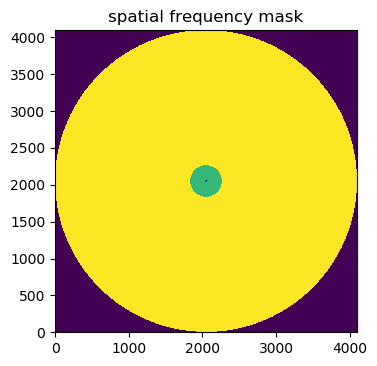

In [8]:
tot_mask = (lmask.astype(np.int))+(mmask.astype(np.int)*2)+(hmask.astype(np.int)*3)

plt.figure(dpi=100)
plt.imshow(tot_mask, origin='lower')
#plt.colorbar()
plt.title('spatial frequency mask')

# Reference code
Exploration type stuff

## Checking interpolation code
This is all pre-built in the "fill_surface" function.

In [176]:
# let's probe the bad OAP data
folder = 'zygo_data/oaps/oap_coated/'
oap_labels =  ('0', '1', '2', '3', '4', '5_sn1', '5_sn2', '5_sn3')

t_oap = 5 # pre-known
filename = folder+'oap{0}_centered'.format(oap_labels[t_oap])
mask_data, mask_header = fits.getdata(filename+'_mask.fits', header=True)
surf_data, surf_header = fits.getdata(filename+'_surf.fits', header=True)
side_len = np.shape(surf_data)[0]

ind, imask = psd.interp_mask(ca_coords, mask_data)
working_data = imask*surf_data*ap_clear
values = working_data[imask.astype(bool)==True]
yy, xx = np.indices(working_data.shape)
mask_points = np.argwhere(imask==1)

grid_z2 = interpolate.griddata(mask_points, values, (yy, xx), method='cubic')

In [177]:
plane = np.ones(mask_data.shape)
plane[imask==0] = np.nan
nan_data = plane*surf_data*ap_clear
print('Compare output data before and after interpolation')
for n in range(0, np.shape(ind)[0]):
    print('Index {0} value: {1:.5f}   |   {2:.5f}'.format(ind[n], nan_data[ind[n][0]][ind[n][1]], grid_z2[ind[n][0]][ind[n][1]]))

print('control index check')
ctrl_ind = [[388, 388], [400,500]]
for n in range(0, np.shape(ctrl_ind)[0]):
    print('Index {0} value: {1:.5f}   |   {2:.5f}'.format(ctrl_ind[n], nan_data[ctrl_ind[n][0]][ctrl_ind[n][1]], grid_z2[ctrl_ind[n][0]][ctrl_ind[n][1]]))

Compare output data before and after interpolation
Index [383, 722] value: nan   |   0.00398
Index [384, 722] value: nan   |   -0.00894
Index [399, 745] value: nan   |   0.01214
Index [400, 714] value: nan   |   0.02104
Index [407, 700] value: nan   |   -0.00359
Index [410, 679] value: nan   |   0.00272
Index [412, 721] value: nan   |   0.02204
Index [415, 670] value: nan   |   0.00313
Index [417, 706] value: nan   |   0.00979
Index [418, 711] value: nan   |   0.01136
Index [419, 695] value: nan   |   -0.03475
Index [421, 671] value: nan   |   0.01384
Index [433, 727] value: nan   |   0.02870
Index [434, 727] value: nan   |   0.00484
Index [437, 735] value: nan   |   0.02067
Index [442, 716] value: nan   |   0.00595
Index [442, 718] value: nan   |   -0.01245
Index [447, 735] value: nan   |   -0.00184
Index [453, 667] value: nan   |   0.00179
Index [456, 733] value: nan   |   0.00175
Index [458, 732] value: nan   |   -0.02352
Index [459, 686] value: nan   |   0.00471
Index [459, 732] va

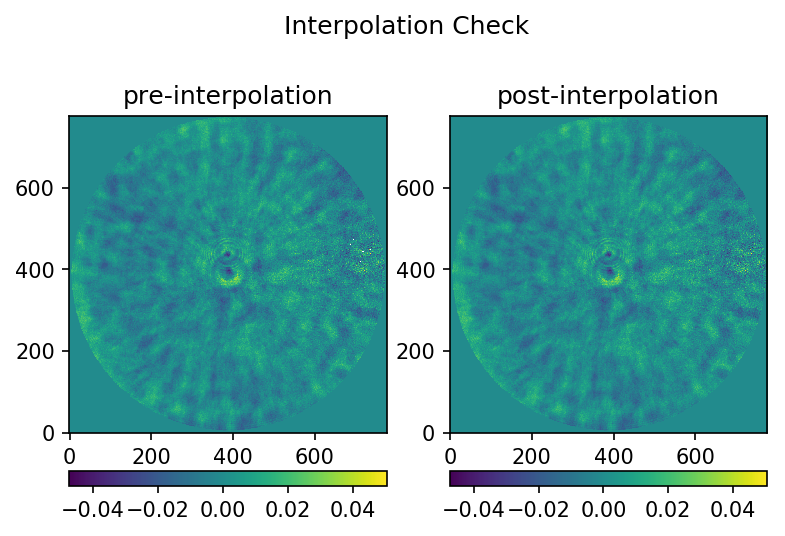

In [157]:
psd.show2plots('Interpolation Check', nan_data, 'pre-interpolation', grid_z2, 'post-interpolation')